In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import git

In [2]:
# variables and files to be apply horizontal averaging to
hor_avg_metadata_list = [
    {'varnames':['thetao'],
     'fname_in':'../omip1/thetao_Oyr_CESM2_omip1_r2i1p1f1_gr_0001-0372.nc',
     'fname_out':'../omip1/thetao_Oyr_CESM2_omip1_r2i1p1f1_gr_hor_avg_0001-0372.nc'},
    {'varnames':['thetao'],
     'fname_in':'../omip2/thetao_Oyr_CESM2_omip2_r1i1p1f1_gr_0001-0366.nc',
     'fname_out':'../omip2/thetao_Oyr_CESM2_omip2_r1i1p1f1_gr_hor_avg_0001-0366.nc'},
    {'varnames':['so'],
     'fname_in':'../omip1/so_Oyr_CESM2_omip1_r2i1p1f1_gr_0001-0372.nc',
     'fname_out':'../omip1/so_Oyr_CESM2_omip1_r2i1p1f1_gr_hor_avg_0001-0372.nc'},
    {'varnames':['so'],
     'fname_in':'../omip2/so_Oyr_CESM2_omip2_r1i1p1f1_gr_0001-0366.nc',
     'fname_out':'../omip2/so_Oyr_CESM2_omip2_r1i1p1f1_gr_hor_avg_0001-0366.nc'},
]

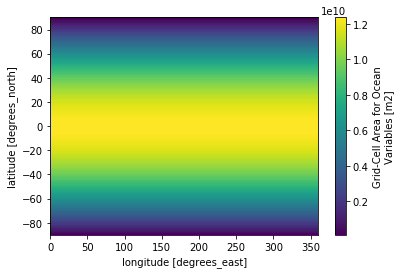

In [3]:
# construct area weights

fname_areacello = 'areacello_Ofx_CESM2_omip2_r1i1p1f1_gr.nc'
area_weight = xr.open_dataset(fname_areacello).areacello
area_weight.plot();

In [4]:
for hor_avg_metadata in hor_avg_metadata_list:
    ds_in = xr.open_dataset(hor_avg_metadata['fname_in'], chunks={'time':1, 'lev':10})
    ds_out = xr.Dataset()
    for varname in hor_avg_metadata['varnames']:
        da_in = ds_in[varname]
        da_out = (da_in * area_weight).sum(dim=['lon', 'lat'])
        ones_masked = xr.ones_like(da_in).where(da_in.notnull())
        denom = (ones_masked * area_weight).sum(dim=['lon', 'lat'])
        da_out /= denom
        da_out.attrs = da_in.attrs

        # delete some attributes that do not make sense for horizontal means
        for attr_name in ['cell_measures', 'cell_methods', 'comment']:
            del da_out.attrs[attr_name]

        # propagate some encoding info from da_in
        for key in ['dtype', '_FillValue', 'zlib', 'complevel']:
            if key in da_in.encoding:
                da_out.encoding[key] = da_in.encoding[key]
        if 'missing_value' in da_in.encoding:
            da_out.attrs['missing_value'] = np.float32(da_in.encoding['missing_value'])

        ds_out[varname] = da_out

    # if any variable in ds_out has a bounds attribute, copy the bounds variable over
    for varname in ds_out.variables:
        if 'bounds' in ds_out[varname].attrs:
            bounds_name = ds_out[varname].attrs['bounds']
            ds_out[bounds_name] = ds_in[bounds_name]

    # if a variable doesn't have _FillValue in the encoding, set _FillValue to None
    for varname in ds_out.variables:
        if '_FillValue' not in ds_out[varname].encoding:
            ds_out[varname].encoding['_FillValue'] = None

    ds_out.attrs = ds_in.attrs
    ds_out.attrs['contact'] = 'klindsay@ucar.edu'
    ds_out.attrs['githash'] = git.Repo(search_parent_directories=True).head.object.hexsha

    ds_out.to_netcdf(hor_avg_metadata['fname_out'],
                     unlimited_dims='time')